<a href="https://colab.research.google.com/github/Pensive1881/jaguar-image-segmentation/blob/main/NS_fastAI_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -*- coding: utf-8 -*-
"""Binary Segmentation with CVAT COCO Format

Adapted for binary foreground/background segmentation using masks from CVAT
exported in COCO 1.0 format.
"""

## Install fastai v2
!pip install -q fastbook==0.0.29
import fastbook
fastbook.setup_book()

import os
from fastbook import *
from fastai.vision.all import * # ADDED: Explicitly import fastai vision components
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Install pycocotools if not already installed
!pip install -q pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.8 MB/s eta 0:00:00
Mounted at /content/gdrive


After setting up the custom splitter, you would typically train your model using `dls_50_25_25` and then evaluate it on the actual test set by creating a `test_dl` from `test_fnames` and using `learn.get_preds(dl=test_dl)`.

In [ ]:

# ============================================================================
# CONFIGURATION - UPDATE THESE PATHS
# ============================================================================

# Path to your CVAT export folder
# Structure should be:
# cvat_export/
#   ├── annotations/
#   │   └── instances_default.json  (or your COCO annotations file)
#   └── images/
#       └── *.jpg/png

cvat_export_path = Path('/content/drive/MyDrive/jaguar_reid')  # UPDATE THIS
annotations_file = cvat_export_path / 'annotations' / 'instances_merged.json'
images_path = cvat_export_path / 'images'

In [ ]:
masks_folder = cvat_export_path / 'binary_masks'
def get_mask_path(image_path):
    """
    Given an image path, return the corresponding mask path.

    Analogy: Like a filing system where every photo has a matching label file
    with the same name but different folder and suffix.
    """
    return masks_folder / f"{image_path.stem}_mask.png"

In [ ]:

# ============================================================================
# STEP 1: Convert COCO format to binary masks
# ============================================================================

def create_binary_masks_from_coco(coco_json_path, images_folder, output_folder):
    """
    Convert COCO annotations to binary masks.

    First Principles:
    - COCO format stores annotations as polygons or RLE (Run Length Encoding)
    - We need to convert these to pixel-wise binary masks (0=background, 1=foreground)
    - Each image gets one mask file where all annotated objects = foreground

    Args:
        coco_json_path: Path to COCO annotations JSON
        images_folder: Path to source images
        output_folder: Path to save binary masks
    """
    # Load COCO annotations
    coco = COCO(coco_json_path)

    # Create output directory
    output_folder = Path(output_folder)
    output_folder.mkdir(exist_ok=True, parents=True)

    # Get all image IDs
    image_ids = coco.getImgIds()

    print(f"Processing {len(image_ids)} images...")

    for img_id in image_ids:
        # Get image info
        img_info = coco.loadImgs(img_id)[0]
        img_filename = img_info['file_name']
        height = img_info['height']
        width = img_info['width']

        # Create empty binary mask
        binary_mask = np.zeros((height, width), dtype=np.uint8)

        # Get all annotations for this image
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        # Combine all annotations into a single binary mask
        for ann in anns:
            # Convert annotation to mask
            mask = coco.annToMask(ann)
            # Add to binary mask (any annotated region = 1)
            binary_mask = np.maximum(binary_mask, mask)

        # Save binary mask (pixels should be 0 or 1 for fastai segmentation targets)
        mask_path = output_folder / f"{Path(img_filename).stem}_mask.png"
        Image.fromarray(binary_mask).save(mask_path)  # Changed: Removed * 255

    print(f"✓ Created {len(image_ids)} binary masks in {output_folder}")
    return output_folder


# Create binary masks
masks_folder = cvat_export_path / 'binary_masks'
create_binary_masks_from_coco(annotations_file, images_path, masks_folder)


loading annotations into memory...
Done (t=5.58s)
creating index...
index created!
Processing 302 images...
✓ Created 302 binary masks in /content/drive/MyDrive/jaguar_reid/binary_masks


Path('/content/drive/MyDrive/jaguar_reid/binary_masks')

In [ ]:
# ============================================================================
# STEP 1: Create custom splitter for 50/25/25 split
# ============================================================================

# Get all image files
all_fnames = get_image_files(images_path)

# Check if any image files were found
if not all_fnames:
    raise ValueError(f"No image files found in '{images_path}'. Please ensure the path is correct and contains images, and that your Google Drive is properly mounted. The previous error concerning the 'Transport endpoint' likely indicates a problem accessing your data.")

# First, perform the 50/25/25 split on the filenames
# This is explicitly done once to get the definitive lists for train, validation, and test.
train_fnames_actual, temp_fnames = train_test_split(all_fnames, test_size=0.5, random_state=42)
valid_fnames_actual, test_fnames_actual = train_test_split(temp_fnames, test_size=0.5, random_state=42)

print(f"Calculated split counts: Train={len(train_fnames_actual)}, Validation={len(valid_fnames_actual)}, Test={len(test_fnames_actual)}")

# Create the lists of indices for the split
train_indices_final = [i for i, o in enumerate(all_fnames) if o in train_fnames_actual]
valid_indices_final = [i for i, o in enumerate(all_fnames) if o in valid_fnames_actual]

# Define the splits explicitly as a tuple of index lists
splits = (train_indices_final, valid_indices_final)

# Binary segmentation codes: background (0) and foreground (1)
binary_codes = np.array(['Background', 'Foreground'])

# Define a custom splitter function for DataBlock
# This function will be called by DataBlock with 'items' (which is 'all_fnames' in this case)
# and should return the (train_indices, valid_indices) tuple.
custom_fastai_splitter = lambda items: splits

seg_block = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=binary_codes)),
    get_items=get_image_files,
    get_y=get_mask_path,
    item_tfms=Resize(256),
    batch_tfms=[
        *aug_transforms(size=224, max_warp=0),
        Normalize.from_stats(*imagenet_stats)
    ],
    splitter=custom_fastai_splitter # Use our custom function that directly returns the splits
)

# Create the DataLoaders from the DataBlock. The custom splitter defined in seg_block will be used.
dls_50_25_25 = seg_block.dataloaders(
    images_path,
    bs=4
)

print(f"Number of items in training set: {len(dls_50_25_25.train_ds)}")
print(f"Number of items in validation set: {len(dls_50_25_25.valid_ds)}")

# To evaluate the 'test' set, you need to create a separate DataLoader from the test_fnames.
test_dl = dls_50_25_25.test_dl(test_fnames_actual)
print(f"Number of items in test set: {len(test_dl.items)}")

Calculated split counts: Train=50, Validation=25, Test=25
Number of items in training set: 50
Number of items in validation set: 25
Number of items in test set: 25


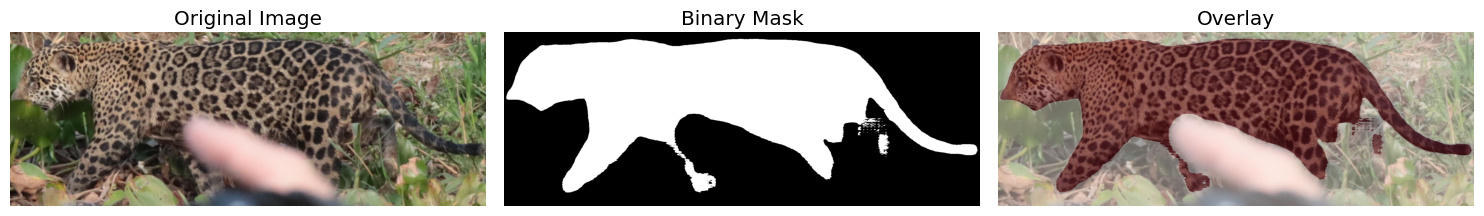

In [ ]:
# ============================================================================
# STEP 2: Verify the masks look correct
# ============================================================================

# Load a sample image and its mask
sample_images = list(images_path.glob('*.jpg')) + list(images_path.glob('*.png'))
if sample_images:
    sample_img = Image.open(sample_images[0])
    sample_mask_path = masks_folder / f"{sample_images[0].stem}_mask.png"
    sample_mask = Image.open(sample_mask_path)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(sample_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(sample_mask, cmap='gray')
    axes[1].set_title('Binary Mask')
    axes[1].axis('off')

    # Overlay
    axes[2].imshow(sample_img)
    axes[2].imshow(np.array(sample_mask), alpha=0.4, cmap='Reds')
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:

# ============================================================================
# STEP 3: Create label function for fastai
# ============================================================================

def get_mask_path(image_path):
    """
    Given an image path, return the corresponding mask path.

    Analogy: Like a filing system where every photo has a matching label file
    with the same name but different folder and suffix.
    """
    return masks_folder / f"{image_path.stem}_mask.png"

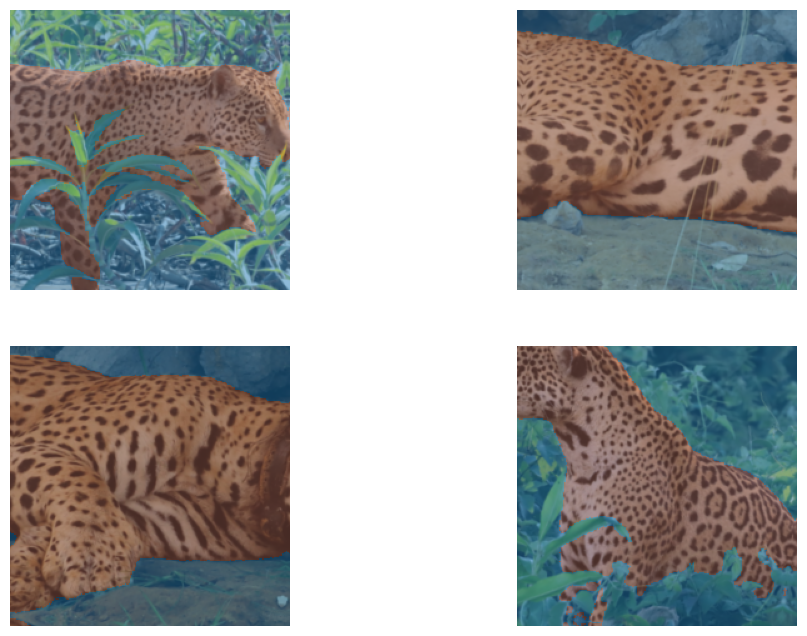

In [ ]:
# ============================================================================
# STEP 4: Create DataLoaders for binary segmentation
# ============================================================================

# Binary segmentation codes: background (0) and foreground (1)
binary_codes = np.array(['Background', 'Foreground'])

# The dls_50_25_25 object with the desired split was already created in a previous step.
# We will use that for visualization and training.

# Visualize a batch from the correctly split DataLoaders
dls_50_25_25.show_batch(max_n=4, figsize=(12, 8))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 237MB/s]


Suggested learning rate: 7.585775892948732e-05


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.701896,0.635473,0.763106,0.832643,00:06


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.541727,0.506852,0.812689,0.899842,00:03
1,0.442310,0.312973,0.869577,0.786245,00:03
2,0.401910,0.311252,0.889598,0.922016,00:03
3,0.348506,0.266572,0.905827,0.891748,00:03
4,0.313610,0.267867,0.905912,0.909683,00:03


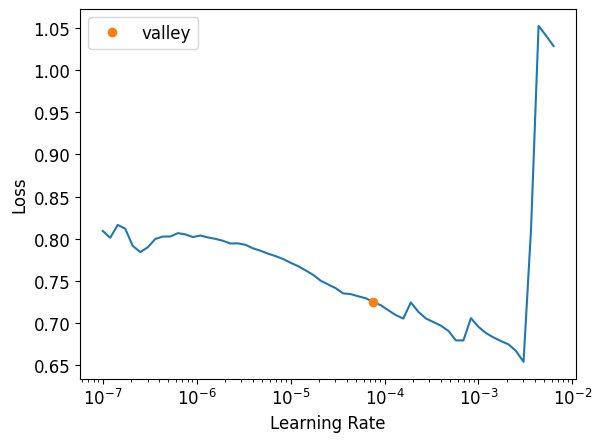

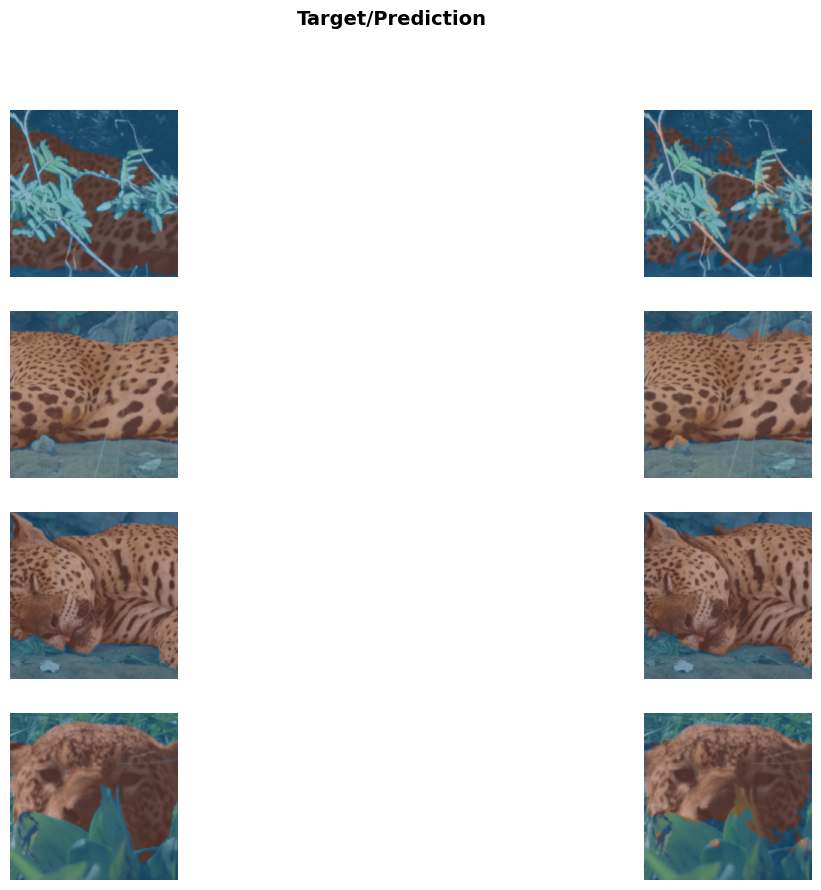

In [ ]:
# ============================================================================
# STEP 5: Create and train the model
# ============================================================================

# Free up GPU memory
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

# Create U-Net learner with ResNet34 backbone
#
# First Principles of U-Net:
# - Encoder (downsampling): Extracts features at multiple scales
# - Decoder (upsampling): Reconstructs the segmentation mask
# - Skip connections: Preserve spatial information from encoder
#
# The pretrained ResNet backbone helps the model start with good feature extractors
# learned from millions of images (transfer learning)

learn = unet_learner(
    dls_50_25_25, # Use the dls object with the 50/25/25 split
    resnet34,  # Using ResNet34 as backbone (deeper than ResNet18, better features)
    pretrained=True,  # Use ImageNet pretrained weights
    metrics=[Dice(), foreground_acc]  # Track Dice score and foreground accuracy
)

# Find optimal learning rate
lrs = learn.lr_find()
print(f"Suggested learning rate: {lrs.valley}")

# Fine-tune the model
# Strategy: Start with a few epochs to see if it's learning
learn.fine_tune(5, base_lr=lrs.valley)

# Show results
learn.show_results(max_n=6, figsize=(15, 10))

epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.292934,0.233646,0.917298,0.915022,00:03


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,0.214416,0.272864,0.889217,0.803282,00:03
1,0.188064,0.213749,0.919787,0.881840,00:03
2,0.191715,0.191617,0.931420,0.928712,00:03
3,0.179000,0.180517,0.936039,0.929786,00:03
4,0.177875,0.228549,0.909293,0.833567,00:03
5,0.176486,0.195916,0.924460,0.866440,00:03
6,0.167371,0.165859,0.939957,0.931194,00:03
7,0.160367,0.160166,0.941795,0.926259,00:03
8,0.152833,0.157103,0.943258,0.936862,00:03
9,0.148062,0.164525,0.941502,0.945296,00:03


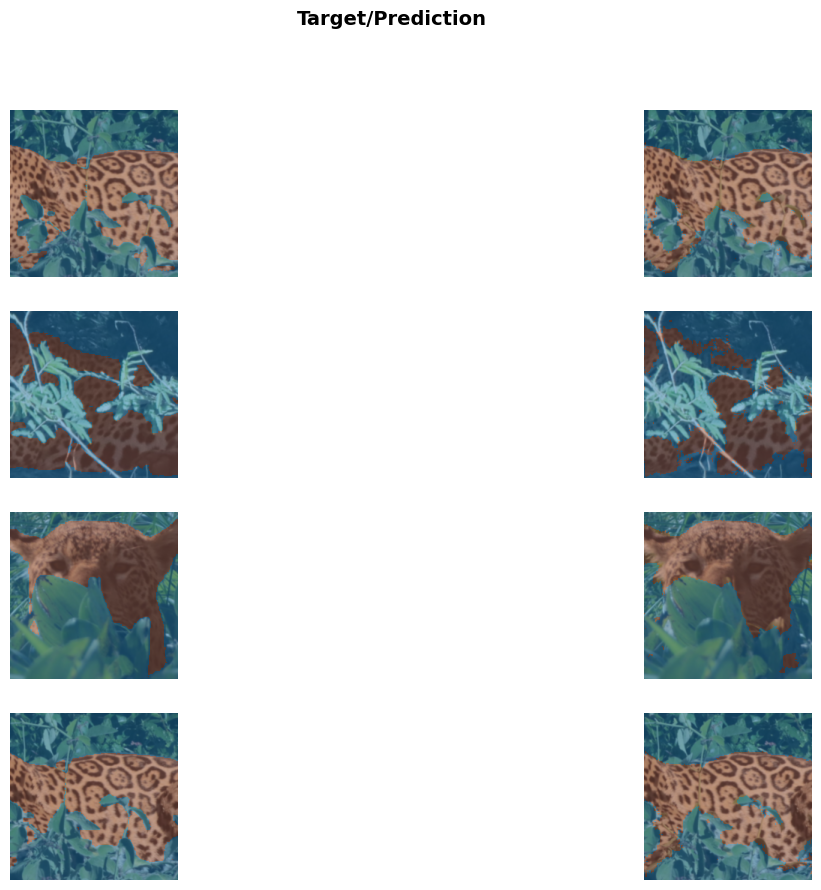

In [ ]:
# ============================================================================
# STEP 6: Additional training (if needed)
# ============================================================================

# If results aren't good enough, train more epochs
learn.fine_tune(10, base_lr=lrs.valley)
learn.show_results(max_n=6, figsize=(15, 10))

In [ ]:
# ============================================================================
# STEP 7: Evaluate model performance
# ============================================================================

# Get predictions on validation set
preds, targets = learn.get_preds()

# Calculate metrics
from sklearn.metrics import confusion_matrix, classification_report

# Flatten predictions and targets for binary classification metrics
preds_flat = preds.argmax(dim=1).flatten().cpu().numpy()
targets_flat = targets.flatten().cpu().numpy()

print("Classification Report:")
print(classification_report(targets_flat, preds_flat,
                           target_names=['Background', 'Foreground']))


Classification Report:
              precision    recall  f1-score   support

  Background       0.94      0.91      0.92    546199
  Foreground       0.93      0.95      0.94    708201

    accuracy                           0.93   1254400
   macro avg       0.93      0.93      0.93   1254400
weighted avg       0.93      0.93      0.93   1254400



In [ ]:
# ============================================================================
# STEP 8: Save the trained model
# ============================================================================

learn.export(cvat_export_path / 'binary_segmentation_model.pkl')
print(f"✓ Model saved to {cvat_export_path / 'binary_segmentation_model.pkl'}")


✓ Model saved to /content/drive/MyDrive/jaguar_reid/binary_segmentation_model.pkl


In [ ]:
# ============================================================================
# STEP 9: Use the model for inference
# ============================================================================

def predict_mask(image_path, model_path):
    """
    Predict binary mask for a new image.

    Application: This is how you'd use your trained model in production
    to segment new images.

    Args:
        image_path: Path to input image
        model_path: Path to saved model (.pkl file)

    Returns:
        Binary mask as numpy array (0=background, 1=foreground)
    """
    # Load model
    learn_inf = load_learner(model_path)

    # Predict
    pred = learn_inf.predict(image_path)

    # Extract binary mask (class 1 = foreground)
    mask = pred[0].numpy()

    return mask

# Example usage:
# test_image = 'path/to/new/image.jpg'
# predicted_mask = predict_mask(test_image, cvat_export_path / 'binary_segmentation_model.pkl')

In [ ]:
# ============================================================================
# ADDITIONAL UTILITIES
# ============================================================================

def visualize_prediction(image_path, model_path):
    """Visualize model prediction on a single image."""
    img = Image.open(image_path)
    mask = predict_mask(image_path, model_path)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')

    axes[2].imshow(img)
    axes[2].imshow(mask, alpha=0.5, cmap='Reds')
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def batch_predict_and_save(input_folder, output_folder, model_path):
    """
    Predict masks for all images in a folder and save them.

    Application: Process multiple images efficiently for production use.
    """
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    output_folder.mkdir(exist_ok=True, parents=True)

    learn_inf = load_learner(model_path)

    for img_path in input_folder.glob('*'):
        if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            mask = predict_mask(img_path, model_path)
            mask_path = output_folder / f"{img_path.stem}_predicted_mask.png"
            Image.fromarray((mask * 255).astype(np.uint8)).save(mask_path)

    print(f"✓ Saved all predictions to {output_folder}")


In [ ]:
# ============================================================================
# HELPER: Custom metrics for binary segmentation
# ============================================================================

def foreground_acc(inp, targ):
    """
    Calculate accuracy on foreground pixels only.

    Why: In binary segmentation, background often dominates. This metric
    focuses on how well we detect the important foreground objects.
    """
    # Only calculate accuracy where target is foreground (class 1)
    foreground_mask = targ == 1
    if foreground_mask.sum() == 0:
        return tensor(0.0)

    pred_classes = inp.argmax(dim=1)
    correct = (pred_classes == targ) & foreground_mask
    return correct.float().sum() / foreground_mask.sum()

print("Setup complete! Follow the steps above to train your binary segmentation model.")

Setup complete! Follow the steps above to train your binary segmentation model.
